In [0]:
!kill -9 -1

In [1]:
!pip install tqdm

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Proyecto Final (Image + Text + Multi-Modal (Image + Text))

### Curso Deep Learning y Redes Neuronales - MIIA4406_01

#### Universidad de los Andes

Integrantes:

|Nombre|Codigo|
|---------------------|---------------------|
|Saby Espinel|*201215868*|
|Diego Salazar|*201628925*| <br>
<br>

## Verificacion de uso de 'GPU'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18232027069371439929]

# Librerias y Funciones

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

In [4]:
!pip install -U -q PyDrive
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Verificacion de contenido de carpetas en el Drive con su respectivo ID
file_list = drive.ListFile({'q': "'1gX_xAhoYwIwmOVRd33lAuf4pCM3cChB6' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: ML_Final.ipynb, id: 10A5sIsjOxbI2D2fGGr4DIqCtzclGeOUG
title: Final Project, id: 11e7vYds1eCR_y760-GMhpE36gOuhP8mCNqN1m9-FOos
title: ML_FinalFinal.ipynb, id: 1ixr9GMNjZ1xSc8Ri39BLyNsz6OCoNABV
title: Final Project.pptx, id: 17-MkUf4ltoGnoNHS8XhuI2PzG0Igd9YF
title: ~$Resultados.xlsx, id: 1T4cMOruAsc2uBupWKfmH-AZa1i83E3tA
title: ImageColab.ipynb, id: 1QI4l_c2wejdKDavNVdmMz6DSP0es2Jf2
title: CombinadoFinal_II.ipynb, id: 1rbSbG8Q6tqM2URX3rGAkVGHvpI_WczB8
title: CombinadoFinal.ipynb, id: 1m2dderm11SQk0T3nkZ2kZXpHJQlaj0lB
title: 0-ColabCombinado, id: 1WhxbiFAE5vCZyu8xLcxpHNKmdTxrS52O
title: pred_genres_img_RF.csv, id: 1l734WEkdZIeCUxGqJw_i0czo1bfm12IR
title: colabcombinado, id: 1Lo3bVt7cHIoOHVPjrbILOW-8ocWGjH0w
title: Resultados.xlsx, id: 1Lykn5EEY4RTyTesTN6f5d0LDm1AqIuGv
title: 0-CombinacionesText, id: 1Lk9Ek6fOIAV6v9ysYe8U8beBpvFEtbPfqVb6tyd-_I4
title: TextColab.ipynb, id: 1sEAr0qGqVwDkmZJjw4o1UC3owfqykJma
title: Combinado.ipynb, id: 1rGKRTd8TTYKGkxvf3_o65MC5hwEK2B6q
title: Resultados

In [0]:
trainDrive = drive.CreateFile({'id': '1SKNGe6FFghASG38LjtUaoTrmozUibRCZ'})
trainDrive.GetContentFile('dataTraining.csv')
dataTraining=pd.read_csv("dataTraining.csv", index_col=0)

testDrive = drive.CreateFile({'id': '1JWWmvheWnofZl2zqY-7Gu2rJprceYB80'})
testDrive.GetContentFile('dataTesting.csv')
dataTesting=pd.read_csv("dataTesting.csv", index_col=0)

In [8]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [9]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Create count vectorizer with ngrams

In [10]:
vect = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

# Text preprocessing

In [0]:
# Definicion de funcion para preprocesar el texto
def preProssText(df, commonWord, numberCommonWords, rareWord, numberRareWords, spellCorrect):
  # Remove punctutation
  df['plot'] = df['plot'].str.replace('[^\w\s]','')
  
  # Lower case
  df['plot'] = df['plot'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  
  # Remove Common words
  if commonWord == True:
    freq = pd.Series(' '.join(df['plot']).split()).value_counts()[:numberCommonWords]
    df['plot'] = df['plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  
  # Remove Rare words
  if rareWord == True:
    freq = pd.Series(' '.join(df['plot']).split()).value_counts()[-numberRareWords:]
    df['plot'] = df['plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
  
  # Spelling correction -> Tener cuidado puede cambiar los valores. Ej: "ur" por "or" en vez de "your"
  if spellCorrect == True:
    from textblob import TextBlob
    df['plot'] = df['plot'].apply(lambda x: str(TextBlob(x).correct()))
    
  return df

In [0]:
# Pre-procesamiento de texto
dataTraining = preProssText(dataTraining, commonWord=True, numberCommonWords=10, rareWord=True, numberRareWords=10, spellCorrect=False)
dataTesting = preProssText(dataTesting, commonWord=True, numberCommonWords=10, rareWord=True, numberRareWords=10, spellCorrect=False)

In [13]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most story single father who takes eight year ...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,serial killer decides teach secrets satisfying...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,sweden female blackmailer with disfiguring fac...,"['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,friday afternoon new york president tredway co...,['Drama'],7.4
2582,1990,Narrow Margin,los angeles editor publishing house carol hunn...,"['Action', 'Crime', 'Thriller']",6.6


In [14]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,who meets by fate shall be sealed by fate ther...
4,1978,Midnight Express,true story billy hayes an american college stu...
5,1996,Primal Fear,martin vail left chicago da office become succ...
6,1950,Crisis,husband wife americans dr eugene mrs helen fer...
7,1959,The Tingler,coroner scientist dr warren chapin researching...


In [15]:
# define a function that accepts text and returns a list of lemmas
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def split_into_lemmas(text):
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [17]:
# Text processing
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [18]:
vect = CountVectorizer(analyzer=split_into_lemmas, ngram_range=(1, 2), max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

# Read images

In [0]:
file_id = '1mcEsaLxakpcQqYZl1pe_qtIEh4FXj0Wx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

In [0]:
# Descomprimir archivo
!unzip -o images_resize_gray.zip

In [0]:
path='images_resize_gray/'

In [0]:
image = io.imread(os.path.join(path, str(dataTraining.index[0]) + '_resize_gray.jpeg'))

In [23]:
image

array([[ 3,  3,  3, ..., 57, 55, 51],
       [ 3,  3,  3, ..., 99, 98, 95],
       [ 3,  3,  3, ..., 97, 96, 94],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

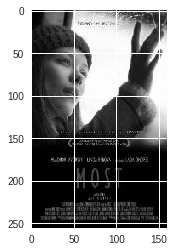

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

In [25]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:04<00:00, 1707.65it/s]


In [26]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [27]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 3383/3383 [00:01<00:00, 1868.81it/s]


In [28]:
images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

((3383, 40960), 3383)

In [0]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_training)

In [0]:
images_testing_pca = pca.transform(images_testing)

# Create Y

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [31]:
y_genres.shape

(7895, 24)

# Split train and test

**Text**

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

**Machine learning**

Text and image are evaluate separately:

Support Vector Machine

In [0]:
from sklearn.svm import SVC

In [37]:
svc=OneVsRestClassifier(svm.SVC(kernel='linear'))

NameError: ignored

In [38]:
svc.fit(X_train, y_train_genres)

NameError: ignored

In [0]:
y_pred_genres = svc.predict(X_test)

In [130]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.64082675457253

In [0]:
#Toma mucho tiempo
from sklearn.cross_validation import cross_val_score
svc=OneVsRestClassifier(svm.SVC(kernel='linear'))
scores = cross_val_score(svc, X_dtm, y_genres, cv=10, scoring='accuracy') #cv is cross validation
print(scores)

In [0]:
print(scores.mean())

In [0]:
C_range=list(range(1,10))
acc_score=[]
for c in C_range:
    svc = OneVsRestClassifier(svm.SVC(kernel='linear', C=c))
    svc.fit(X_train, y_train_genres)
    y_pred_genres = svc.predict(X_test)
    scores = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
    acc_score.append(scores)
print(acc_score) 

Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
lr=OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [73]:
lr.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres = lr.predict_proba(X_test)

In [75]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7968778530403938

Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [0]:
rf=OneVsRestClassifier(RandomForestClassifier())

In [77]:
rf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres = rf.predict_proba(X_test)

In [79]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.6828515840350059

In [0]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = lr.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')

In [0]:
files.download('pred_genres_img_RF.csv')

**Images**

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

Support Vector Machine

In [0]:
svc=OneVsRestClassifier(svm.SVC())

In [106]:
svc.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [0]:
y_pred_genres = svc.predict(X_test)

In [108]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.500710191484001

Logistic Regression

In [0]:
lr=OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [88]:
lr.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres = lr.predict_proba(X_test)

In [90]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.6137839464894191

Random Forest Classifier

In [0]:
rf=OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [97]:
rf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres = rf.predict_proba(X_test)

In [99]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5871600253921408

Now, we try text and image together using a Logistic Regression:

In [0]:
from scipy.sparse import csr_matrix

In [0]:
csr=csr_matrix(X_dtm, dtype=np.int8).toarray()

In [0]:
img=pd.DataFrame(images_training_pca)

In [0]:
text=pd.DataFrame(csr)

In [49]:
img.shape

(7895, 32)

In [50]:
text.shape

(7895, 1000)

In [51]:
y_genres.shape

(7895, 24)

In [0]:
txtimg=pd.concat([img, text],  axis=1)

In [0]:
lr=OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [53]:
lr.fit(txtimg, y_genres)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect whe

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
X_test_dtm = vect.transform(dataTesting['plot'])

In [0]:
csr_test=csr_matrix(X_test_dtm, dtype=np.int8).toarray()

In [0]:
img=pd.DataFrame(images_testing_pca)

In [61]:
img.shape

(3383, 32)

In [0]:
text=pd.DataFrame(csr_test)

In [63]:
text.shape

(3383, 1000)

In [0]:
import pandas as pd

In [0]:
txtimg_test=pd.concat([img, text],  axis=1)

In [0]:
y_pred_genres = lr.predict_proba(txtimg_test)

In [70]:
y_genres.shape

(7895, 24)

In [69]:
y_pred_genres.shape

(3383, 24)

In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = lr.predict_proba(txtimg_test)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [0]:
files.download('pred_genres_img_RF.csv')